<a href="https://colab.research.google.com/github/HMoreyP/Senado_Federal/blob/main/Senado_Federal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Objetivos do Projeto**

Utilizando a API do Senado Federal, o projeto tem como objetivo entender um pouco como é a composição do Senado nas últimas 5 legislaturas, ou seja, analisar, por meio de visualizações, a distribuição de senadores em cada partido.

Para isso o projeto téra algumas etapas. São elas:

1.   Visualização e entendimento dos dados selecionados;

2.   Análise da quantidade de senadores por partido

3.   Linha temporal dos partidos ao longo das legislaturas

4.   Maior orçamento significa mais senadores no partido?

#**Início**

Precisamos fazer alguns imports que serão usados futuramente.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import xml.etree.ElementTree as ET
import plotly.express as px

#**1. Visualização e entendimento dos dados selecionados**

Nesta seção o intuito é selecionar os dados que usaremos futuramente e tentar entender um pouco como eles estão estruturados.

Como a ideia do projeto é estudar um pouco a distribuição dos senadores por partido no Senado, foi feita uma função que busca na API os seguintes dados de cada senador:

*   Legislatura
*   ID
*   Nome
*   Partido



In [2]:
# Função para obter senadores de uma legislatura específica
def obter_senadores_por_legislatura(legislatura):

  # URL base da API do Senado para receber lista de senadores que exerceram alguma atividade em certa legislatura
  URL_BASE = "https://legis.senado.leg.br/dadosabertos/senador/lista/legislatura/"

  # Definir headers para evitar bloqueios
  HEADERS = {
    "User-Agent": "Mozilla/5.0"
  }

  params = {
    "exercicio": "S",  # Apenas senadores que exerceram o mandato
    "participacao": "T"  # Apenas titulares
  }

  url = f"{URL_BASE}{legislatura}"

  # Fazendo uma requisição get passando o que foi definido acima
  response = requests.get(url, headers=HEADERS, params=params)
  # Lança erro se a requisição falhar
  response.raise_for_status()

  # Parseando XML
  root = ET.fromstring(response.content)

  lista_de_senadores = []

  """
  Percorrendo os senadores da legislatura
  Procurando por todos os Parlamentar abaixo do nó atual
  """
  for parlamentar in root.findall(".//Parlamentar"):

    identificacao = parlamentar.find("IdentificacaoParlamentar")

    if identificacao is not None:
      # Adiciona um dicionário com informações do senador na lista de senadores
      lista_de_senadores.append({
        "Legislatura": legislatura,
        "ID": identificacao.findtext("CodigoParlamentar"),
        "Nome": identificacao.findtext("NomeParlamentar"),
        "Partido": identificacao.findtext("SiglaPartidoParlamentar")
        })

  df = pd.DataFrame(lista_de_senadores)

  # Retorna DataFrame com os senadores e partidos
  return df

In [3]:
# Criando DataFrame para armazenar os dados de todas as legislaturas
df_partidos_legislaturas = pd.DataFrame()

# Definindo as legislaturas
legislatura_atual = 57
num_legislaturas_analisadas = 5

Para melhor enxergar os dados, será apresentado apenas os dados de uma legislatura, já que o intuito é entender um pouco como os dados estão dispostos.

Após a coleta dos dados da API obtive o seguinte DataFrame.

Uma observação importante sobre os dados é que pode não ter 81 senadores, o que não está errado, já que a API retorna **todos** os senadores que entraram em **exercício** durante **toda** a legislatura.

Olhando o DataFrame podemos ver que os dados foram consumidos corretamente, ou seja, temos as legislaturas, ID, nome e partido de cada senador.

In [4]:
# Chamando a função e passando a legislatura atual
df_legislatura = obter_senadores_por_legislatura(57)

df_legislatura.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Legislatura  82 non-null     int64 
 1   ID           82 non-null     object
 2   Nome         82 non-null     object
 3   Partido      81 non-null     object
dtypes: int64(1), object(3)
memory usage: 2.7+ KB


Note que no DataFrame acima mostra que na coluna "Partido" está faltando um dado, já que de 82 apenas 81 são não null. Isso é confirmado logo abaixo.

In [5]:
df_legislatura.isna().sum()

Legislatura    0
ID             0
Nome           0
Partido        1
dtype: int64

Agora, após tratado os dados faltantes, note que a DataFrame está completa, ou seja, não temos mais dados ausentes.

In [6]:
df_legislatura["Partido"] = df_legislatura["Partido"].fillna("Sem Partido")
df_legislatura.isna().sum()

Legislatura    0
ID             0
Nome           0
Partido        0
dtype: int64

Como não há dados duplicados, não terá um tratamento de dados para esse caso.

In [7]:
df_legislatura.duplicated().sum()

np.int64(0)

Como a ideia é entender um pouco sobre a quantidade de senadores por partido, o DataFrame abaixo mostra a quantidade de senador por partido.

Para esse cálculo foi utilizado os dados do DataFrame acima.

In [8]:
# Somando a quantidade de senador por partido
contagem_partidos = df_legislatura["Partido"].value_counts()

# Criando um DataFrame para colocar a quantidade de senadores em cada partido
df_contagem = pd.DataFrame(contagem_partidos)
df_contagem.columns = [f"Legislatura {57}"] # cada coluna recebe o número da legislatura
df_contagem

Legislatura 57
Partido                     
PSD                       15
PL                        13
PT                        10
MDB                        9
UNIÃO                      7
PODEMOS                    6
PP                         6
PSB                        5
REPUBLICANOS               4
PSDB                       3
PDT                        2
NOVO                       1
Sem Partido                1

Agora que já entendemos como os dados estão organizados, vamos analisar alguns gráficos e tentar tirar alguns insights deles.

#**2. Análise da quantidade de senadores por partido**

A ideia aqui é tentar entender, a partir de um gráfico de barras empilhadas, a quantidade de senadores por partido ao longo das legislaturas 53 à 57 e tirar algo desse gráfico.

In [9]:
# Percorrendo todas as legislaturas a serem estudadas (57, 56, 55, 54, 53)
for legislatura in range(legislatura_atual, legislatura_atual - num_legislaturas_analisadas, -1):

  """
  Chamando a função passando o número da legislatura e
  recebendo um DataFrame com os IDs, Nomes e Partidos de cada senador
  """
  df_legislatura = obter_senadores_por_legislatura(legislatura)

  # Tratando os dados ausentes e linhas duplicadas
  df_legislatura["Partido"] = df_legislatura["Partido"].fillna("Sem Partido")
  df_legislatura.drop_duplicates(inplace=True)

  if not df_legislatura.empty: # caso o consumo da API tenha dado certo, ou seja, tenha elementos no df

    # Contando quantos senadores tem em cada Partido na legislatura em questão
    contagem_partidos = df_legislatura["Partido"].value_counts()

    # Criando um DataFrame para colocar a quantidade de senadores em cada partido
    df_contagem = pd.DataFrame(contagem_partidos)
    df_contagem.columns = [f"Legislatura {legislatura}"] # cada coluna recebe o número da legislatura

    # Juntando os dados da legislatura em questão no DataFrame com os valores senadores/partido
    df_partidos_legislaturas = pd.concat([df_partidos_legislaturas, df_contagem], axis=1)

O DataFrame abaixo nos mostra a quantidade de senador em cada partido em cada legislatura.

Por exemplo, na legislatura 57 o PSD teve 15 senadores. Já na legislatura 53 o PSD não teve nenhum senador.

In [10]:
df_partidos_legislaturas

Legislatura 57  Legislatura 56  Legislatura 55  Legislatura 54  \
Partido                                                                        
PSD                     15.0            16.0             4.0             1.0   
PL                      13.0             7.0             6.0             5.0   
PT                      10.0             8.0            10.0            10.0   
MDB                      9.0            12.0            19.0            19.0   
UNIÃO                    7.0             3.0             1.0             1.0   
PODEMOS                  6.0             8.0             2.0             1.0   
PP                       6.0             7.0             8.0             7.0   
PSB                      5.0             5.0             6.0             6.0   
REPUBLICANOS             4.0             1.0             2.0             2.0   
PSDB                     3.0             5.0             9.0            12.0   
PDT                      2.0             3.0             3.0             4.0   
NOVO                     1.0             1.0             NaN             NaN   
Sem Partido              1.0             1.0             1.0             1.0   
PTB                      NaN             2.0             3.0             5.0   
S/Partido                NaN             1.0             4.0             3.0   
DEM                      NaN             1.0             2.0             4.0   
PROS                     NaN             1.0             1.0             NaN   
CIDADANIA                NaN             NaN             1.0             1.0   
PSOL                     NaN             NaN             1.0             1.0   
PCdoB                    NaN             NaN             1.0             2.0   
PV                       NaN             NaN             NaN             NaN   
PSC                      NaN             NaN             NaN             NaN   

              Legislatura 53  
Partido                       
PSD                      NaN  
PL                       4.0  
PT                       8.0  
MDB                     18.0  
UNIÃO                    1.0  
PODEMOS                  1.0  
PP                       3.0  
PSB                      5.0  
REPUBLICANOS             1.0  
PSDB                    12.0  
PDT                      4.0  
NOVO                     NaN  
Sem Partido              5.0  
PTB                      7.0  
S/Partido                3.0  
DEM                      7.0  
PROS                     NaN  
CIDADANIA                1.0  
PSOL                     NaN  
PCdoB                    1.0  
PV                       1.0  
PSC                      1.0

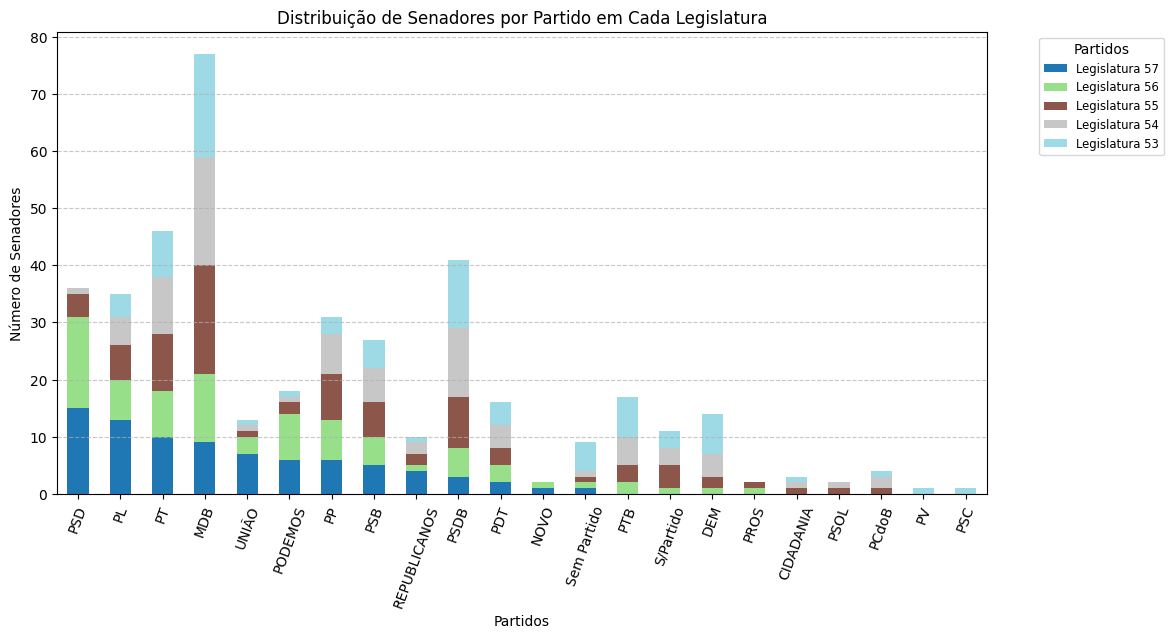

In [11]:
# Criar Gráfico de Barras Empilhadas
df_partidos_legislaturas.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab20")

# Rotulando os eixos e dando título para o gráfico
plt.xlabel("Partidos")
plt.ylabel("Número de Senadores")
plt.title("Distribuição de Senadores por Partido em Cada Legislatura")

# Rotação dos Partidos para leitura melhor
plt.xticks(rotation=70)

# Adicionando legenda
plt.legend(title="Partidos", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")
# Adicionando grid
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

O gráfico apresenta a distribuição do número de senadores por partido ao longo de cinco legislaturas (da 53ª à 57ª).

Cada barra representa um partido, cada cor representa uma legislatura e o tamanho de cada cor em cada barra é como se fosse a quantidade de senadores na legislatura em questão.

Olhando o gráfico, podemos inferir algumas informações.


1.**MDB** é historicamente dominante, mas perdeu força


*   O **MDB** sempre teve um alto número de senadores mas sua participação tem diminuido ao longo das últimas legislaturas. Pode ser que o partido esteja perdendo influência no Senado.

2.**PSD** e **PL** estão crescendo

*   Olhando para as legislaturas mais recentes, pricipalmente a (57), podemos notar que o **PSD** e o **PL** estão crescendo. Talvez indique que esses partidos estão conseguindo atrair mais senadores e podem estar se fortalecendo politicamente.


3.O **PSDB** sofreu uma grande queda

*   O **PSDB**, que já foi um partido com alta influência no Senado, aparece com um número reduzido de senadores nas últimas legislaturas. Isso pode refletiir na perda de representatividade do partido no Senado.


# **Conclusão**

O gráfico aponta uma mudança da política no Senado, com partidos que possuiam grande número de senadores, como MDB e PSDB, perdendo força, enquanto outros partidos como PSD e PL vêm ganhando espaço.

#**3. Linha temporal dos partidos ao longo das legislaturas**

Nesta seção vou usar dados já coletados anteriormente mas agora a ideia é tentar visualizar a evolução do número de senadores de cada partido ao longo das legislaturas analisadas.

Para isso, será plotado um gráfico temporal de linha e então será tirado algumas conclusões dele.

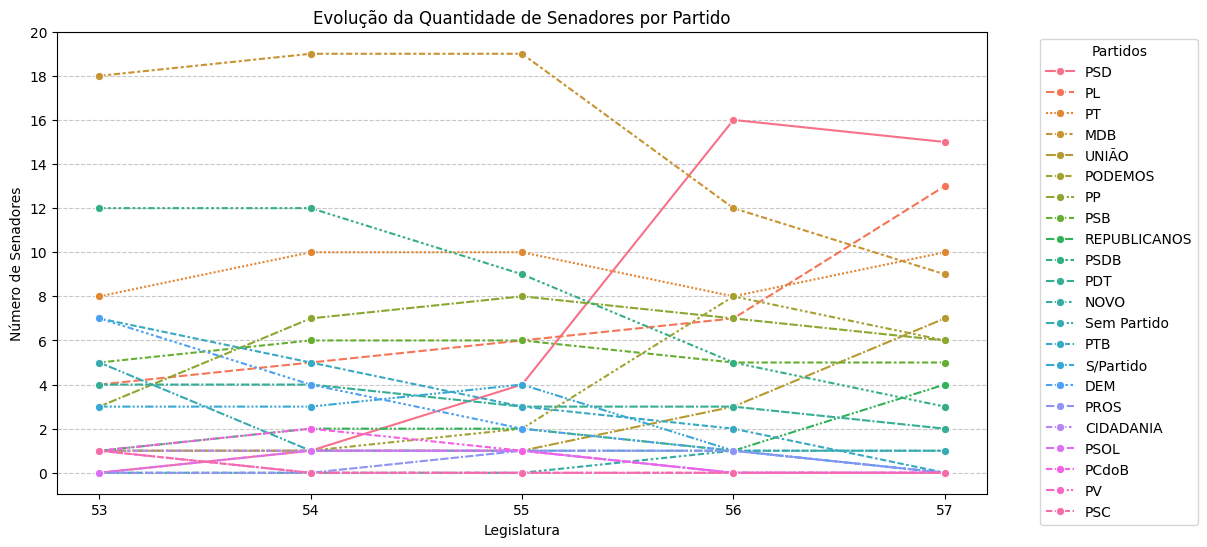

In [12]:
# Verificando se a API foi consumida corretamente
if df_partidos_legislaturas.empty:
  print("Nenhum dado encontrado após filtragem.")
else:
  # Transpondo o DataFrame porque a ideia é que a legislatura seja a variável temporal
  df_partidos_legislaturas = df_partidos_legislaturas.T

  # Aqui está tratando os dados ausentes (NaN)
  df_partidos_legislaturas = df_partidos_legislaturas.fillna(0)

  # Para o eixo x não ficar escrito "Legistalura X" onde X = {57, 56, 55, 54, 53}
  # Aqui está extraindo apenas o número da string
  df_partidos_legislaturas.index = df_partidos_legislaturas.index.str.extract(r"(\d+)")[0].astype(int)

  # Apenas definindo tamanho do gráfico e usando Seaborn para criar o gráfico
  plt.figure(figsize=(12, 6))
  sns.lineplot(data=df_partidos_legislaturas, marker="o", dashes=True)

  # Rotulando os eixos e dando título para o gráfico  plt.xlabel("Legislatura")
  plt.xlabel("Legislatura")
  plt.ylabel("Número de Senadores")
  plt.title("Evolução da Quantidade de Senadores por Partido")

  # Ajustar os valores do eixo X para números inteiros e bem espaçados
  x_ticks = np.arange(df_partidos_legislaturas.index.min(), df_partidos_legislaturas.index.max() + 1, 1)
  plt.xticks(x_ticks)

  # Pegando o maior valor de cada Partido
  y_max = df_partidos_legislaturas.max()
  # Pegando o maior valor entre todos os Partidos
  y_max = y_max.max()
  # Define passos de 2 para o eixo Y
  y_ticks = np.arange(0, y_max + 2, 2)
  plt.yticks(y_ticks)

  # Adicionando legenda
  plt.legend(title="Partidos", bbox_to_anchor=(1.05, 1), loc="upper left")
  # Adicionando griid
  plt.grid(axis="y", linestyle="--", alpha=0.7)

  plt.show()

O gráfico representa a evolução do número de senadores por partido ao longo das legislaturas 53, 54, 55, 56 e 57. Cada linha corresponde a um partido político e mostra como a quantidade de senadores variou ao longo do tempo.


**1.   Crescimento do PSD e PL**


*   O **PSD** representado pela linha rosa contínua, teve um crescimento expressivo na 56ª legislatura, mas depois apresentou uma pequena queda na 57ª. O **PL**, representado por uma linha alaranjada e tracejada, também demonstra uma trajetória crescente. Essa leitura pode indicar uma preferência dos eleitores.

**2.   Declínio do MDB**

*   O **MDB**, que historicamente teve forte presença no Senado, mostra uma grande queda após a 56ª legislatura. Isso pode refletir numa perda de influência no Senado.

**3.   Estabilidade de Alguns Partidos**

*   O **PT**, por exemplo, sugere que mantém um eleitorado fiel e uma presença constante no Senado, já que o número de senadores se manteve quase o mesmo durante as legislaturas estudadas.

**4.   Aparição e Desaparecimento de Partidos**

*   Alguns partidos com menos senadores que aparecem em algumas legislaturas e desaparecem nas seguintes pode indicar que ouve uma junção com outro partido ou então uma mudança de nome.

#**Conclusão**

Note que o gráfico sugere que o cenário político do Senado Federal está em constante transformação.

Assim como existem partidos numa crescente, existem também os que estão em declínio e os que se mantiveram praticamente com o mesmo número de senadores.

#**Podemos pensar que essa mudança pode estar ligada a fatores como mudanças ideológicas e/ou desempenho eleitoral.**

A partir do DataFrame abaixo farei uma análise sobre a composição do Senado.

In [13]:
# Apenas nomeando a coluna legislatura
df_partidos_legislaturas.index.name = "Legislatura"
df_partidos_legislaturas

Partido       PSD    PL    PT   MDB  UNIÃO  PODEMOS   PP  PSB  REPUBLICANOS  \
Legislatura                                                                   
57           15.0  13.0  10.0   9.0    7.0      6.0  6.0  5.0           4.0   
56           16.0   7.0   8.0  12.0    3.0      8.0  7.0  5.0           1.0   
55            4.0   6.0  10.0  19.0    1.0      2.0  8.0  6.0           2.0   
54            1.0   5.0  10.0  19.0    1.0      1.0  7.0  6.0           2.0   
53            0.0   4.0   8.0  18.0    1.0      1.0  3.0  5.0           1.0   

Partido      PSDB  ...  Sem Partido  PTB  S/Partido  DEM  PROS  CIDADANIA  \
Legislatura        ...                                                      
57            3.0  ...          1.0  0.0        0.0  0.0   0.0        0.0   
56            5.0  ...          1.0  2.0        1.0  1.0   1.0        0.0   
55            9.0  ...          1.0  3.0        4.0  2.0   1.0        1.0   
54           12.0  ...          1.0  5.0        3.0  4.0   0.0        1.0   
53           12.0  ...          5.0  7.0        3.0  7.0   0.0        1.0   

Partido      PSOL  PCdoB   PV  PSC  
Legislatura                         
57            0.0    0.0  0.0  0.0  
56            0.0    0.0  0.0  0.0  
55            1.0    1.0  0.0  0.0  
54            1.0    2.0  0.0  0.0  
53            0.0    1.0  1.0  1.0  

[5 rows x 22 columns]

Abaixo temos a soma de todos os senadores de cada partido nas últimas 5 legislaturas.

Note que apenas está mostrando os 5 primeiros do DataFrame.

In [14]:
"""
Somando senadores de cada partido, ou seja,
PSD = leg57 + leg56 + leg55 + leg54 + leg53
PSD = 15 + 16 + 4 + 1 + 0 = 36
"""
soma_senadores_por_partido = df_partidos_legislaturas.sum()

# Criando um DataFrame e recebendo os dados acima
soma_senadores_por_partido_df = soma_senadores_por_partido.reset_index()
soma_senadores_por_partido_df.columns = ["Partido", "Total de Senadores"]

soma_senadores_por_partido_df.head()

Partido  Total de Senadores
0     PSD                36.0
1      PL                35.0
2      PT                46.0
3     MDB                77.0
4   UNIÃO                13.0

O DataFrame abaixo apresenta o total de senadores por partido ordenados de forma crescente, ou seja, do menor número de senadores para o maior.

Além disso, note que está sendo mostrado apenas os primeiros cinco valores e não o Dataframe todo.

In [15]:
# Ordenando o DataFrame pela coluna "Total de Senadores" de forma crescente
soma_senadores_por_partido_df = soma_senadores_por_partido_df.sort_values(by="Total de Senadores", ascending=True)
soma_senadores_por_partido_df.head()

Partido  Total de Senadores
20      PV                 1.0
21     PSC                 1.0
11    NOVO                 2.0
16    PROS                 2.0
18    PSOL                 2.0

Agora o DataFrame não possui mais a quantidade de senadores de cada partido e sim a porcentagem correspondente, ou seja, o partido PV possui 0,240385% e o partido PSOL possui 0,480769%.

In [16]:
# Encontrando a quantidade total de senadores, ou seja, somando os números da coluna "Total de Senadores"
soma_total_senadores = soma_senadores_por_partido_df["Total de Senadores"].sum()

# Calculando a porcentagem de senadores em cada partido político
soma_senadores_por_partido_df["Total de Senadores"] = soma_senadores_por_partido_df["Total de Senadores"] / soma_total_senadores * 100

# Renomeando a segunda coluna, ou seja, a coluna "Total de Senadores" vira "Porcentagem"
df_resultante = pd.DataFrame({"Partido": soma_senadores_por_partido_df["Partido"], "Porcentagem": soma_senadores_por_partido_df["Total de Senadores"]})
df_resultante.head()

Partido  Porcentagem
20      PV     0.240385
21     PSC     0.240385
11    NOVO     0.480769
16    PROS     0.480769
18    PSOL     0.480769

Abaixo temos um gráfico de barras horizontal

In [17]:
fig = px.bar(df_resultante, x="Porcentagem", y="Partido", orientation="h")
fig.show()